# Facebook Prophet для прогнозирования временных рядов 

Time Series in Python and Prophet


In [7]:
import numpy as np                               # работа с векторами и матрицами
import pandas as pd                              # таблицы и операции над данными
import matplotlib.pyplot as plt                  # графики
import seaborn as sns                            # еще графики

from dateutil.relativedelta import relativedelta # для комфортной работы с датами
from scipy.optimize import minimize              # позволяет минимизировать функции

import statsmodels.formula.api as smf            # всякая статистика и эконометрика
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # немножко функций для удобства
from tqdm import tqdm_notebook

import warnings                                  # скрыть ошибки кода
warnings.filterwarnings('ignore')

%matplotlib inline


In [10]:
ads = pd.read_csv('ads.csv', index_col=['Time'], parse_dates=['Time'])
currency = pd.read_csv('currency.csv', index_col=['Time'], parse_dates=['Time'])

In [13]:
ts = pd.read_csv('dataset1_with_outliers_data.csv')
ts.index = pd.to_datetime(ts['ds'])
ts.sort_index(inplace=True)

ts_test = ts[datetime(2015,1,1):]

ts_full = ts[:datetime(2015,1,1)]
ts_no_outs = ts_full[datetime(2012, 1,1):]

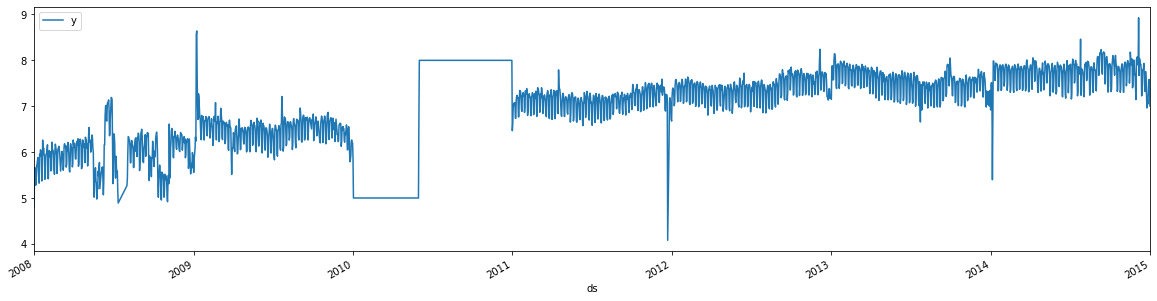

In [14]:
ts_full.plot(figsize=(20,5))

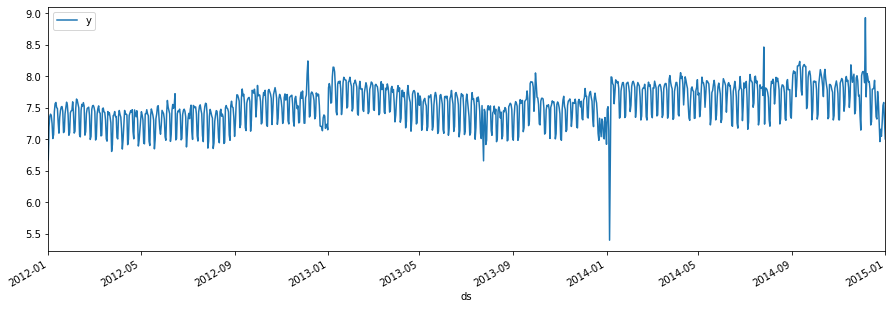

In [15]:
ts_no_outs.plot(figsize=(15,5))

# Проверка на стационарность

In [16]:
ts_no_outs

,ds,y
ds,,
2012-01-01,2012-01-01,6.675823
2012-01-02,2012-01-02,7.194437
2012-01-03,2012-01-03,7.362645
2012-01-04,2012-01-04,7.396949
2012-01-05,2012-01-05,7.374629
2012-01-06,2012-01-06,7.247081
2012-01-07,2012-01-07,7.010312
2012-01-08,2012-01-08,7.073270
2012-01-09,2012-01-09,7.437795


критерий Дики-Фуллера

In [18]:
print(" Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(ts_no_outs['y'])[1])

 Критерий Дики-Фуллера: p=0.074175


In [19]:
def transform(df):
    plt.figure(figsize=(15,10))
    sm.tsa.seasonal_decompose(df['y'], freq = 30).plot()
    print(" Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df['y'])[1])

Обнаружение выбросов:

In [22]:
def exponential_smoothing_anomaly_filter(series, alpha, beta=2.5, std_window=10):



    result = [series[0]] # first value is same as series
    sx = series.rolling(std_window).std()
    anomalies_index = []
    anomalies_values = []
#     print(len(series), len(sx))
    for n in range(1, len(series)):
        if n > std_window:
            if abs(series[n] - result[n-1]) > sx[n]*beta:
                result.append(result[n-1])
                anomalies_index.append(series.index[n])
                anomalies_values.append(series[n])
                continue
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(index=series.index, data=result), pd.Series(index=anomalies_index, data=anomalies_values)

In [23]:
ts_no_outs['ty'], ts_no_outs['ay'] = exponential_smoothing_anomaly_filter(ts_no_outs['y'], 0.35, 1.5, 29)
dk = sm.tsa.stattools.adfuller(ts_no_outs['ty'])[1]
dk

0.01918734883565836

 Критерий Дики-Фуллера: p=0.019187


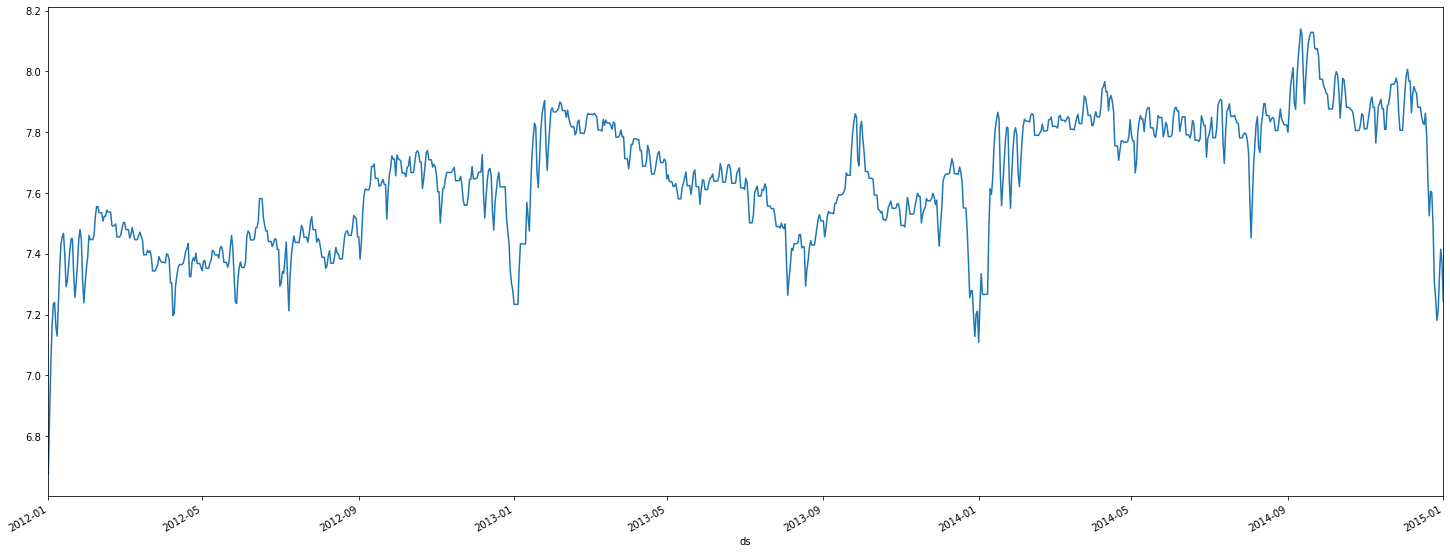

In [24]:
plt.figure(figsize=(25,10))
ts_no_outs['ty'].plot()
print(" Критерий Дики-Фуллера: p=%f" % dk)

#  Построение прогнозов с помощью библиотеки Facebook Prophet (50%)

In [30]:
from fbprophet import Prophet
import logging
logging.getLogger('fbprophet').setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore")
fmodel = Prophet()


fmodel.fit(ts_no_outs)
future = fmodel.make_future_dataframe(periods=365)

forecast = fmodel.predict(future)

In [28]:
conda install -c conda-forge fbprophet

Solving environment: ...working... 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/win-64::anaconda==2019.07=py37_0
  - defaults/win-64::numba==0.44.1=py37hf9181ef_0
done

## Package Plan ##

  environment location: C:\Users\darya\Anaconda3

  added / updated specs:
    - fbprophet


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _anaconda_depends-2019.03  |           py37_0           6 KB
    anaconda-custom            |           py37_1           3 KB
    ca-certificates-2020.4.5.1 |       hecc5488_0         184 KB  conda-forge
    certifi-2020.4.5.1         |   py37hc8dfbb8_0         150 KB  conda-forge
    conda-4.8.3                |   py37hc8dfbb8_1         3.1 MB  conda-forge
    convertdate-2.1.3          |          py_1000          30 KB  conda-forge
    ephem-3.7.7.1              |   

pystan-2.19.0.0      | 11.9 MB   | #4         |  14% 
pystan-2.19.0.0      | 11.9 MB   | #4         |  15% 
pystan-2.19.0.0      | 11.9 MB   | #5         |  15% 
pystan-2.19.0.0      | 11.9 MB   | #5         |  16% 
pystan-2.19.0.0      | 11.9 MB   | #6         |  16% 
pystan-2.19.0.0      | 11.9 MB   | #6         |  17% 
pystan-2.19.0.0      | 11.9 MB   | #7         |  17% 
pystan-2.19.0.0      | 11.9 MB   | #7         |  17% 
pystan-2.19.0.0      | 11.9 MB   | #7         |  18% 
pystan-2.19.0.0      | 11.9 MB   | #8         |  18% 
pystan-2.19.0.0      | 11.9 MB   | #8         |  19% 
pystan-2.19.0.0      | 11.9 MB   | #9         |  19% 
pystan-2.19.0.0      | 11.9 MB   | #9         |  20% 
pystan-2.19.0.0      | 11.9 MB   | ##         |  20% 
pystan-2.19.0.0      | 11.9 MB   | ##         |  20% 
pystan-2.19.0.0      | 11.9 MB   | ##         |  21% 
pystan-2.19.0.0      | 11.9 MB   | ##1        |  21% 
pystan-2.19.0.0      | 11.9 MB   | ##1        |  22% 
pystan-2.19.0.0      | 11.9 

pystan-2.19.0.0      | 11.9 MB   | ########2  |  83% 
pystan-2.19.0.0      | 11.9 MB   | ########3  |  84% 
pystan-2.19.0.0      | 11.9 MB   | ########4  |  84% 
pystan-2.19.0.0      | 11.9 MB   | ########4  |  85% 
pystan-2.19.0.0      | 11.9 MB   | ########5  |  85% 
pystan-2.19.0.0      | 11.9 MB   | ########5  |  86% 
pystan-2.19.0.0      | 11.9 MB   | ########6  |  86% 
pystan-2.19.0.0      | 11.9 MB   | ########6  |  87% 
pystan-2.19.0.0      | 11.9 MB   | ########7  |  87% 
pystan-2.19.0.0      | 11.9 MB   | ########7  |  88% 
pystan-2.19.0.0      | 11.9 MB   | ########7  |  88% 
pystan-2.19.0.0      | 11.9 MB   | ########8  |  88% 
pystan-2.19.0.0      | 11.9 MB   | ########8  |  89% 
pystan-2.19.0.0      | 11.9 MB   | ########9  |  89% 
pystan-2.19.0.0      | 11.9 MB   | ########9  |  90% 
pystan-2.19.0.0      | 11.9 MB   | #########  |  90% 
pystan-2.19.0.0      | 11.9 MB   | #########  |  90% 
pystan-2.19.0.0      | 11.9 MB   | #########  |  91% 
pystan-2.19.0.0      | 11.9 

m2w64-gcc-fortran-5. | 10.3 MB   | ####4      |  45% 
m2w64-gcc-fortran-5. | 10.3 MB   | ####5      |  46% 
m2w64-gcc-fortran-5. | 10.3 MB   | ####6      |  46% 
m2w64-gcc-fortran-5. | 10.3 MB   | ####7      |  47% 
m2w64-gcc-fortran-5. | 10.3 MB   | ####7      |  48% 
m2w64-gcc-fortran-5. | 10.3 MB   | ####8      |  49% 
m2w64-gcc-fortran-5. | 10.3 MB   | ####9      |  49% 
m2w64-gcc-fortran-5. | 10.3 MB   | #####      |  50% 
m2w64-gcc-fortran-5. | 10.3 MB   | #####      |  51% 
m2w64-gcc-fortran-5. | 10.3 MB   | #####1     |  51% 
m2w64-gcc-fortran-5. | 10.3 MB   | #####2     |  52% 
m2w64-gcc-fortran-5. | 10.3 MB   | #####3     |  53% 
m2w64-gcc-fortran-5. | 10.3 MB   | #####4     |  54% 
m2w64-gcc-fortran-5. | 10.3 MB   | #####4     |  55% 
m2w64-gcc-fortran-5. | 10.3 MB   | #####5     |  56% 
m2w64-gcc-fortran-5. | 10.3 MB   | #####6     |  57% 
m2w64-gcc-fortran-5. | 10.3 MB   | #####7     |  58% 
m2w64-gcc-fortran-5. | 10.3 MB   | #####8     |  58% 
m2w64-gcc-fortran-5. | 10.3 

matplotlib-base-3.2. | 7.1 MB    | #7         |  18% 
matplotlib-base-3.2. | 7.1 MB    | #8         |  19% 
matplotlib-base-3.2. | 7.1 MB    | #9         |  19% 
matplotlib-base-3.2. | 7.1 MB    | ##         |  21% 
matplotlib-base-3.2. | 7.1 MB    | ##1        |  22% 
matplotlib-base-3.2. | 7.1 MB    | ##2        |  23% 
matplotlib-base-3.2. | 7.1 MB    | ##4        |  24% 
matplotlib-base-3.2. | 7.1 MB    | ##5        |  25% 
matplotlib-base-3.2. | 7.1 MB    | ##7        |  27% 
matplotlib-base-3.2. | 7.1 MB    | ##8        |  28% 
matplotlib-base-3.2. | 7.1 MB    | ##9        |  30% 
matplotlib-base-3.2. | 7.1 MB    | ###1       |  31% 
matplotlib-base-3.2. | 7.1 MB    | ###2       |  33% 
matplotlib-base-3.2. | 7.1 MB    | ###4       |  35% 
matplotlib-base-3.2. | 7.1 MB    | ###6       |  36% 
matplotlib-base-3.2. | 7.1 MB    | ###7       |  38% 
matplotlib-base-3.2. | 7.1 MB    | ###9       |  39% 
matplotlib-base-3.2. | 7.1 MB    | ####       |  41% 
matplotlib-base-3.2. | 7.1 M

m2w64-gcc-objc-5.3.0 | 15.1 MB   | ####6      |  47% 
m2w64-gcc-objc-5.3.0 | 15.1 MB   | ####7      |  47% 
m2w64-gcc-objc-5.3.0 | 15.1 MB   | ####8      |  48% 
m2w64-gcc-objc-5.3.0 | 15.1 MB   | ####8      |  49% 
m2w64-gcc-objc-5.3.0 | 15.1 MB   | ####9      |  50% 
m2w64-gcc-objc-5.3.0 | 15.1 MB   | #####      |  50% 
m2w64-gcc-objc-5.3.0 | 15.1 MB   | #####      |  51% 
m2w64-gcc-objc-5.3.0 | 15.1 MB   | #####1     |  52% 
m2w64-gcc-objc-5.3.0 | 15.1 MB   | #####2     |  53% 
m2w64-gcc-objc-5.3.0 | 15.1 MB   | #####3     |  53% 
m2w64-gcc-objc-5.3.0 | 15.1 MB   | #####4     |  54% 
m2w64-gcc-objc-5.3.0 | 15.1 MB   | #####4     |  55% 
m2w64-gcc-objc-5.3.0 | 15.1 MB   | #####5     |  55% 
m2w64-gcc-objc-5.3.0 | 15.1 MB   | #####5     |  56% 
m2w64-gcc-objc-5.3.0 | 15.1 MB   | #####5     |  56% 
m2w64-gcc-objc-5.3.0 | 15.1 MB   | #####6     |  56% 
m2w64-gcc-objc-5.3.0 | 15.1 MB   | #####6     |  57% 
m2w64-gcc-objc-5.3.0 | 15.1 MB   | #####7     |  57% 
m2w64-gcc-objc-5.3.0 | 15.1 

m2w64-gcc-5.3.0      | 41.1 MB   | 8          |   8% 
m2w64-gcc-5.3.0      | 41.1 MB   | 8          |   8% 
m2w64-gcc-5.3.0      | 41.1 MB   | 8          |   8% 
m2w64-gcc-5.3.0      | 41.1 MB   | 8          |   9% 
m2w64-gcc-5.3.0      | 41.1 MB   | 8          |   9% 
m2w64-gcc-5.3.0      | 41.1 MB   | 9          |   9% 
m2w64-gcc-5.3.0      | 41.1 MB   | 9          |   9% 
m2w64-gcc-5.3.0      | 41.1 MB   | 9          |   9% 
m2w64-gcc-5.3.0      | 41.1 MB   | 9          |  10% 
m2w64-gcc-5.3.0      | 41.1 MB   | 9          |  10% 
m2w64-gcc-5.3.0      | 41.1 MB   | 9          |  10% 
m2w64-gcc-5.3.0      | 41.1 MB   | 9          |  10% 
m2w64-gcc-5.3.0      | 41.1 MB   | #          |  10% 
m2w64-gcc-5.3.0      | 41.1 MB   | #          |  10% 
m2w64-gcc-5.3.0      | 41.1 MB   | #          |  11% 
m2w64-gcc-5.3.0      | 41.1 MB   | #1         |  11% 
m2w64-gcc-5.3.0      | 41.1 MB   | #1         |  11% 
m2w64-gcc-5.3.0      | 41.1 MB   | #1         |  12% 
m2w64-gcc-5.3.0      | 41.1 

m2w64-gcc-5.3.0      | 41.1 MB   | ####6      |  46% 
m2w64-gcc-5.3.0      | 41.1 MB   | ####6      |  47% 
m2w64-gcc-5.3.0      | 41.1 MB   | ####7      |  47% 
m2w64-gcc-5.3.0      | 41.1 MB   | ####7      |  47% 
m2w64-gcc-5.3.0      | 41.1 MB   | ####7      |  48% 
m2w64-gcc-5.3.0      | 41.1 MB   | ####8      |  48% 
m2w64-gcc-5.3.0      | 41.1 MB   | ####8      |  48% 
m2w64-gcc-5.3.0      | 41.1 MB   | ####8      |  49% 
m2w64-gcc-5.3.0      | 41.1 MB   | ####9      |  49% 
m2w64-gcc-5.3.0      | 41.1 MB   | ####9      |  49% 
m2w64-gcc-5.3.0      | 41.1 MB   | ####9      |  50% 
m2w64-gcc-5.3.0      | 41.1 MB   | ####9      |  50% 
m2w64-gcc-5.3.0      | 41.1 MB   | #####      |  50% 
m2w64-gcc-5.3.0      | 41.1 MB   | #####      |  51% 
m2w64-gcc-5.3.0      | 41.1 MB   | #####      |  51% 
m2w64-gcc-5.3.0      | 41.1 MB   | #####1     |  51% 
m2w64-gcc-5.3.0      | 41.1 MB   | #####1     |  51% 
m2w64-gcc-5.3.0      | 41.1 MB   | #####1     |  51% 
m2w64-gcc-5.3.0      | 41.1 

m2w64-gcc-5.3.0      | 41.1 MB   | ########8  |  89% 
m2w64-gcc-5.3.0      | 41.1 MB   | ########9  |  89% 
m2w64-gcc-5.3.0      | 41.1 MB   | ########9  |  90% 
m2w64-gcc-5.3.0      | 41.1 MB   | ########9  |  90% 
m2w64-gcc-5.3.0      | 41.1 MB   | #########  |  90% 
m2w64-gcc-5.3.0      | 41.1 MB   | #########  |  90% 
m2w64-gcc-5.3.0      | 41.1 MB   | #########  |  91% 
m2w64-gcc-5.3.0      | 41.1 MB   | #########  |  91% 
m2w64-gcc-5.3.0      | 41.1 MB   | #########1 |  91% 
m2w64-gcc-5.3.0      | 41.1 MB   | #########1 |  91% 
m2w64-gcc-5.3.0      | 41.1 MB   | #########1 |  92% 
m2w64-gcc-5.3.0      | 41.1 MB   | #########1 |  92% 
m2w64-gcc-5.3.0      | 41.1 MB   | #########2 |  92% 
m2w64-gcc-5.3.0      | 41.1 MB   | #########2 |  92% 
m2w64-gcc-5.3.0      | 41.1 MB   | #########2 |  93% 
m2w64-gcc-5.3.0      | 41.1 MB   | #########2 |  93% 
m2w64-gcc-5.3.0      | 41.1 MB   | #########3 |  93% 
m2w64-gcc-5.3.0      | 41.1 MB   | #########3 |  93% 
m2w64-gcc-5.3.0      | 41.1 

m2w64-gcc-ada-5.3.0  | 33.5 MB   | #9         |  20% 
m2w64-gcc-ada-5.3.0  | 33.5 MB   | #9         |  20% 
m2w64-gcc-ada-5.3.0  | 33.5 MB   | ##         |  20% 
m2w64-gcc-ada-5.3.0  | 33.5 MB   | ##         |  20% 
m2w64-gcc-ada-5.3.0  | 33.5 MB   | ##         |  21% 
m2w64-gcc-ada-5.3.0  | 33.5 MB   | ##1        |  21% 
m2w64-gcc-ada-5.3.0  | 33.5 MB   | ##1        |  21% 
m2w64-gcc-ada-5.3.0  | 33.5 MB   | ##1        |  22% 
m2w64-gcc-ada-5.3.0  | 33.5 MB   | ##1        |  22% 
m2w64-gcc-ada-5.3.0  | 33.5 MB   | ##2        |  22% 
m2w64-gcc-ada-5.3.0  | 33.5 MB   | ##2        |  23% 
m2w64-gcc-ada-5.3.0  | 33.5 MB   | ##2        |  23% 
m2w64-gcc-ada-5.3.0  | 33.5 MB   | ##3        |  23% 
m2w64-gcc-ada-5.3.0  | 33.5 MB   | ##3        |  23% 
m2w64-gcc-ada-5.3.0  | 33.5 MB   | ##3        |  24% 
m2w64-gcc-ada-5.3.0  | 33.5 MB   | ##3        |  24% 
m2w64-gcc-ada-5.3.0  | 33.5 MB   | ##3        |  24% 
m2w64-gcc-ada-5.3.0  | 33.5 MB   | ##4        |  24% 
m2w64-gcc-ada-5.3.0  | 33.5 

m2w64-gcc-ada-5.3.0  | 33.5 MB   | #####7     |  57% 
m2w64-gcc-ada-5.3.0  | 33.5 MB   | #####7     |  58% 
m2w64-gcc-ada-5.3.0  | 33.5 MB   | #####7     |  58% 
m2w64-gcc-ada-5.3.0  | 33.5 MB   | #####8     |  58% 
m2w64-gcc-ada-5.3.0  | 33.5 MB   | #####8     |  59% 
m2w64-gcc-ada-5.3.0  | 33.5 MB   | #####8     |  59% 
m2w64-gcc-ada-5.3.0  | 33.5 MB   | #####9     |  59% 
m2w64-gcc-ada-5.3.0  | 33.5 MB   | #####9     |  60% 
m2w64-gcc-ada-5.3.0  | 33.5 MB   | ######     |  60% 
m2w64-gcc-ada-5.3.0  | 33.5 MB   | ######     |  60% 
m2w64-gcc-ada-5.3.0  | 33.5 MB   | ######     |  61% 
m2w64-gcc-ada-5.3.0  | 33.5 MB   | ######1    |  61% 
m2w64-gcc-ada-5.3.0  | 33.5 MB   | ######1    |  61% 
m2w64-gcc-ada-5.3.0  | 33.5 MB   | ######1    |  62% 
m2w64-gcc-ada-5.3.0  | 33.5 MB   | ######2    |  62% 
m2w64-gcc-ada-5.3.0  | 33.5 MB   | ######2    |  62% 
m2w64-gcc-ada-5.3.0  | 33.5 MB   | ######2    |  63% 
m2w64-gcc-ada-5.3.0  | 33.5 MB   | ######2    |  63% 
m2w64-gcc-ada-5.3.0  | 33.5 

m2w64-gcc-ada-5.3.0  | 33.5 MB   | #########8 |  98% 
m2w64-gcc-ada-5.3.0  | 33.5 MB   | #########8 |  98% 
m2w64-gcc-ada-5.3.0  | 33.5 MB   | #########8 |  99% 
m2w64-gcc-ada-5.3.0  | 33.5 MB   | #########9 |  99% 
m2w64-gcc-ada-5.3.0  | 33.5 MB   | #########9 |  99% 
m2w64-gcc-ada-5.3.0  | 33.5 MB   | #########9 | 100% 
m2w64-gcc-ada-5.3.0  | 33.5 MB   | ########## | 100% 

m2w64-libmangle-git- | 21 KB     |            |   0% 
m2w64-libmangle-git- | 21 KB     | #######4   |  74% 
m2w64-libmangle-git- | 21 KB     | ########## | 100% 

tbb-2020.1           | 167 KB    |            |   0% 
tbb-2020.1           | 167 KB    | 9          |  10% 
tbb-2020.1           | 167 KB    | ####7      |  48% 
tbb-2020.1           | 167 KB    | ######6    |  67% 
tbb-2020.1           | 167 KB    | ########6  |  86% 
tbb-2020.1           | 167 KB    | ########## | 100% 

m2w64-bzip2-1.0.6    | 100 KB    |            |   0% 
m2w64-bzip2-1.0.6    | 100 KB    | #5         |  16% 
m2w64-bzip2-1.0.6    | 10

m2w64-headers-git-5. | 5.6 MB    | ##9        |  29% 
m2w64-headers-git-5. | 5.6 MB    | ###1       |  31% 
m2w64-headers-git-5. | 5.6 MB    | ###3       |  33% 
m2w64-headers-git-5. | 5.6 MB    | ###4       |  35% 
m2w64-headers-git-5. | 5.6 MB    | ###6       |  36% 
m2w64-headers-git-5. | 5.6 MB    | ###8       |  38% 
m2w64-headers-git-5. | 5.6 MB    | ###9       |  40% 
m2w64-headers-git-5. | 5.6 MB    | ####1      |  41% 
m2w64-headers-git-5. | 5.6 MB    | ####3      |  43% 
m2w64-headers-git-5. | 5.6 MB    | ####4      |  45% 
m2w64-headers-git-5. | 5.6 MB    | ####6      |  46% 
m2w64-headers-git-5. | 5.6 MB    | ####8      |  49% 
m2w64-headers-git-5. | 5.6 MB    | #####      |  51% 
m2w64-headers-git-5. | 5.6 MB    | #####2     |  52% 
m2w64-headers-git-5. | 5.6 MB    | #####3     |  54% 
m2w64-headers-git-5. | 5.6 MB    | #####5     |  56% 
m2w64-headers-git-5. | 5.6 MB    | #####7     |  57% 
m2w64-headers-git-5. | 5.6 MB    | #####8     |  59% 
m2w64-headers-git-5. | 5.6 M

m2w64-binutils-2.25. | 44.3 MB   | 7          |   7% 
m2w64-binutils-2.25. | 44.3 MB   | 7          |   7% 
m2w64-binutils-2.25. | 44.3 MB   | 7          |   8% 
m2w64-binutils-2.25. | 44.3 MB   | 7          |   8% 
m2w64-binutils-2.25. | 44.3 MB   | 7          |   8% 
m2w64-binutils-2.25. | 44.3 MB   | 7          |   8% 
m2w64-binutils-2.25. | 44.3 MB   | 7          |   8% 
m2w64-binutils-2.25. | 44.3 MB   | 7          |   8% 
m2w64-binutils-2.25. | 44.3 MB   | 8          |   8% 
m2w64-binutils-2.25. | 44.3 MB   | 8          |   8% 
m2w64-binutils-2.25. | 44.3 MB   | 8          |   8% 
m2w64-binutils-2.25. | 44.3 MB   | 8          |   8% 
m2w64-binutils-2.25. | 44.3 MB   | 8          |   8% 
m2w64-binutils-2.25. | 44.3 MB   | 8          |   8% 
m2w64-binutils-2.25. | 44.3 MB   | 8          |   9% 
m2w64-binutils-2.25. | 44.3 MB   | 8          |   9% 
m2w64-binutils-2.25. | 44.3 MB   | 8          |   9% 
m2w64-binutils-2.25. | 44.3 MB   | 8          |   9% 
m2w64-binutils-2.25. | 44.3 

m2w64-binutils-2.25. | 44.3 MB   | ###1       |  31% 
m2w64-binutils-2.25. | 44.3 MB   | ###1       |  31% 
m2w64-binutils-2.25. | 44.3 MB   | ###1       |  32% 
m2w64-binutils-2.25. | 44.3 MB   | ###1       |  32% 
m2w64-binutils-2.25. | 44.3 MB   | ###1       |  32% 
m2w64-binutils-2.25. | 44.3 MB   | ###1       |  32% 
m2w64-binutils-2.25. | 44.3 MB   | ###2       |  32% 
m2w64-binutils-2.25. | 44.3 MB   | ###2       |  32% 
m2w64-binutils-2.25. | 44.3 MB   | ###2       |  32% 
m2w64-binutils-2.25. | 44.3 MB   | ###2       |  33% 
m2w64-binutils-2.25. | 44.3 MB   | ###2       |  33% 
m2w64-binutils-2.25. | 44.3 MB   | ###2       |  33% 
m2w64-binutils-2.25. | 44.3 MB   | ###3       |  33% 
m2w64-binutils-2.25. | 44.3 MB   | ###3       |  33% 
m2w64-binutils-2.25. | 44.3 MB   | ###3       |  34% 
m2w64-binutils-2.25. | 44.3 MB   | ###3       |  34% 
m2w64-binutils-2.25. | 44.3 MB   | ###3       |  34% 
m2w64-binutils-2.25. | 44.3 MB   | ###4       |  34% 
m2w64-binutils-2.25. | 44.3 

m2w64-binutils-2.25. | 44.3 MB   | #####9     |  60% 
m2w64-binutils-2.25. | 44.3 MB   | #####9     |  60% 
m2w64-binutils-2.25. | 44.3 MB   | ######     |  60% 
m2w64-binutils-2.25. | 44.3 MB   | ######     |  60% 
m2w64-binutils-2.25. | 44.3 MB   | ######     |  60% 
m2w64-binutils-2.25. | 44.3 MB   | ######     |  60% 
m2w64-binutils-2.25. | 44.3 MB   | ######     |  61% 
m2w64-binutils-2.25. | 44.3 MB   | ######     |  61% 
m2w64-binutils-2.25. | 44.3 MB   | ######     |  61% 
m2w64-binutils-2.25. | 44.3 MB   | ######     |  61% 
m2w64-binutils-2.25. | 44.3 MB   | ######1    |  61% 
m2w64-binutils-2.25. | 44.3 MB   | ######1    |  61% 
m2w64-binutils-2.25. | 44.3 MB   | ######1    |  61% 
m2w64-binutils-2.25. | 44.3 MB   | ######1    |  61% 
m2w64-binutils-2.25. | 44.3 MB   | ######1    |  62% 
m2w64-binutils-2.25. | 44.3 MB   | ######1    |  62% 
m2w64-binutils-2.25. | 44.3 MB   | ######1    |  62% 
m2w64-binutils-2.25. | 44.3 MB   | ######1    |  62% 
m2w64-binutils-2.25. | 44.3 

m2w64-binutils-2.25. | 44.3 MB   | #######4   |  75% 
m2w64-binutils-2.25. | 44.3 MB   | #######4   |  75% 
m2w64-binutils-2.25. | 44.3 MB   | #######4   |  75% 
m2w64-binutils-2.25. | 44.3 MB   | #######5   |  75% 
m2w64-binutils-2.25. | 44.3 MB   | #######5   |  75% 
m2w64-binutils-2.25. | 44.3 MB   | #######5   |  75% 
m2w64-binutils-2.25. | 44.3 MB   | #######5   |  76% 
m2w64-binutils-2.25. | 44.3 MB   | #######5   |  76% 
m2w64-binutils-2.25. | 44.3 MB   | #######5   |  76% 
m2w64-binutils-2.25. | 44.3 MB   | #######6   |  76% 
m2w64-binutils-2.25. | 44.3 MB   | #######6   |  76% 
m2w64-binutils-2.25. | 44.3 MB   | #######6   |  76% 
m2w64-binutils-2.25. | 44.3 MB   | #######6   |  76% 
m2w64-binutils-2.25. | 44.3 MB   | #######6   |  77% 
m2w64-binutils-2.25. | 44.3 MB   | #######6   |  77% 
m2w64-binutils-2.25. | 44.3 MB   | #######7   |  77% 
m2w64-binutils-2.25. | 44.3 MB   | #######7   |  77% 
m2w64-binutils-2.25. | 44.3 MB   | #######7   |  77% 
m2w64-binutils-2.25. | 44.3 



==> WARNING: A newer version of conda exists. <==
  current version: 4.7.12
  latest version: 4.8.3

Please update conda by running

    $ conda update -n base -c defaults conda


WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename C:\Users\darya\Anaconda3\Lib\site-packages\matplotlib\mpl-data\fonts\ttf\DejaVuSans.ttf.  Please remove this file manually (you may need to reboot to free file handles)



Note: you may need to restart the kernel to use updated packages.


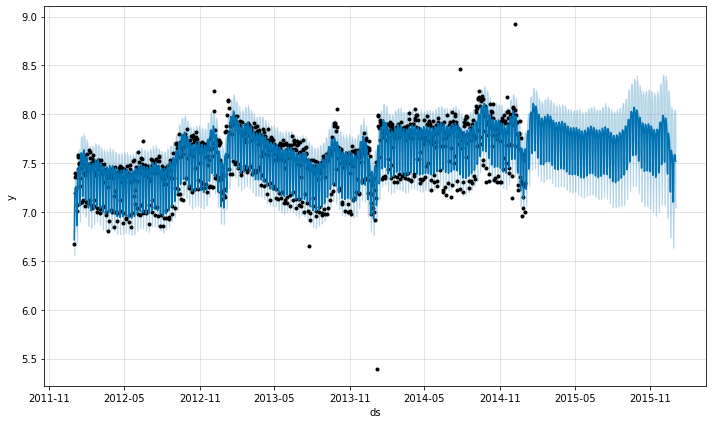

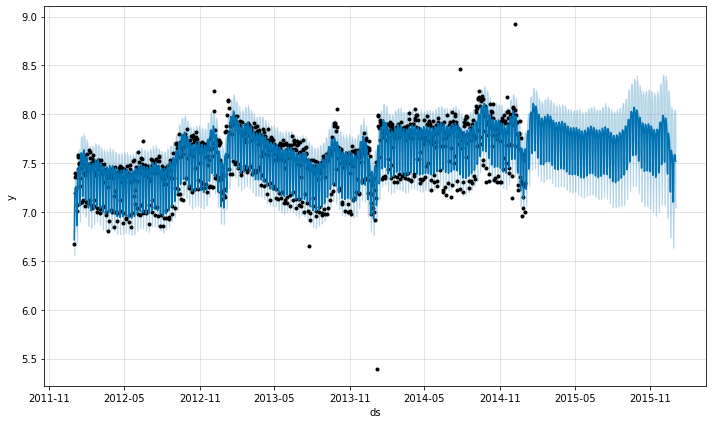

In [31]:
fmodel.plot(forecast)

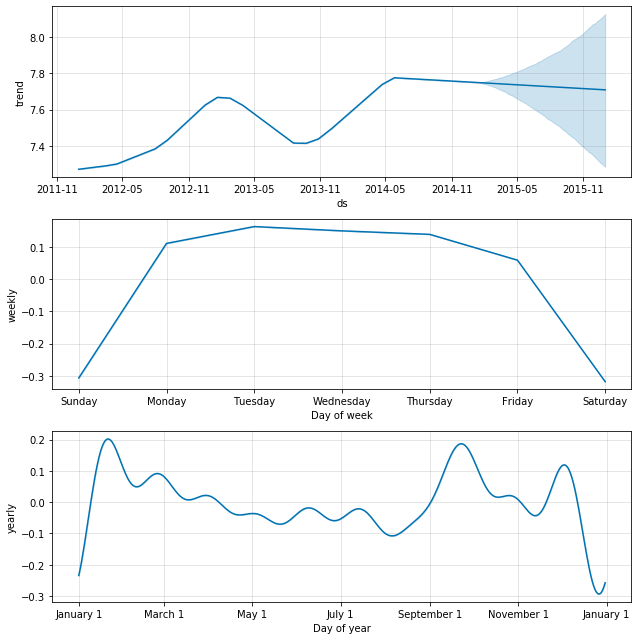

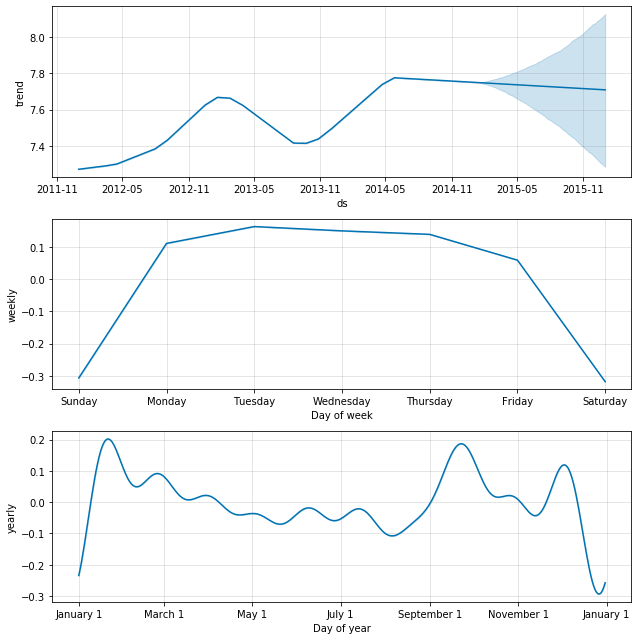

In [32]:
fmodel.plot_components(forecast)

ts_full

In [33]:
fmodel1 = Prophet()

fmodel1.fit(ts_full)
future1 = fmodel1.make_future_dataframe(periods=365)

forecast1 = fmodel1.predict(future1)

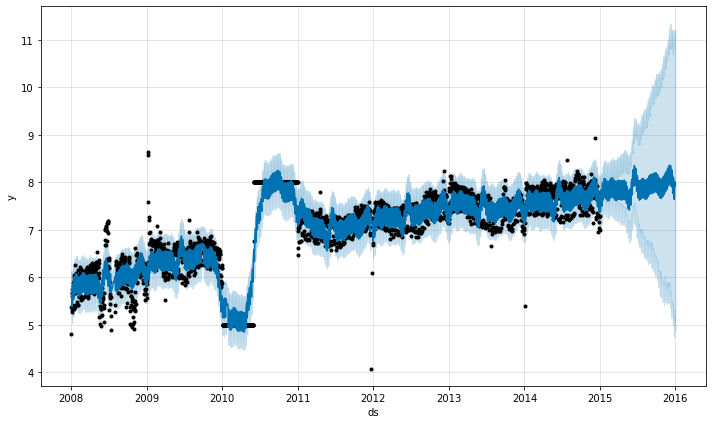

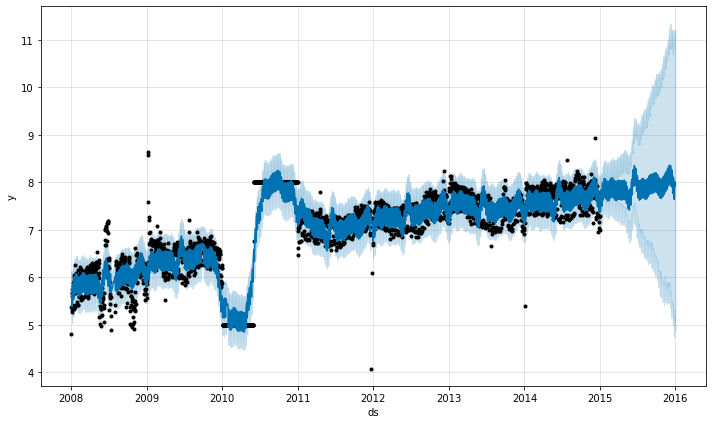

In [34]:
fmodel1.plot(forecast1)

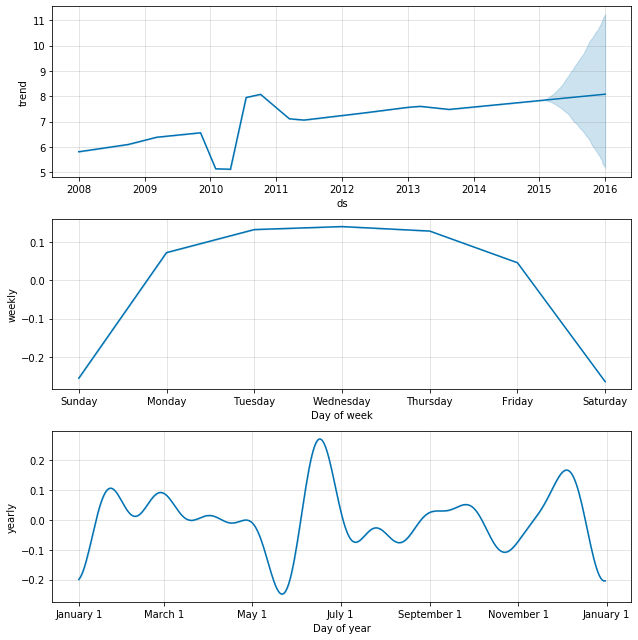

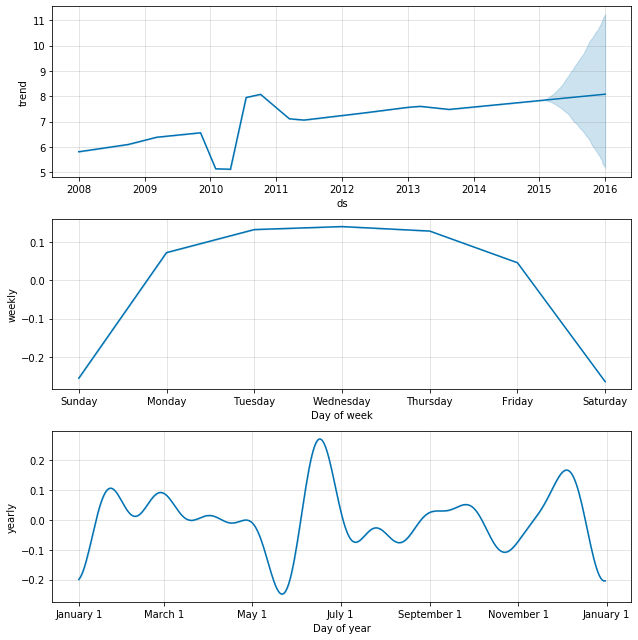

In [35]:
fmodel1.plot_components(forecast1)

Качество прогноза с помощью MSE, MAE и $r^2$-score 

In [36]:
def make_comparison_dataframe(historical, forecast):
    """Join the history with the forecast.
    
       The resulting dataset will contain columns 'yhat', 'yhat_lower', 'yhat_upper' and 'y'.
    """
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(historical.set_index('ds'))

In [37]:
cmp_df  = make_comparison_dataframe(ts_no_outs, forecast)

In [38]:
import numpy as np
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100*cmp_df['e']/cmp_df['y']
print('MSE {}'.format(np.mean(abs(cmp_df[datetime(2015,1,1):]['p']))))
print('MAE {}'.format(np.mean(abs(cmp_df[datetime(2015,1,1):]['e']))))

MSE 9.171853243470927
MAE 0.642394229030864


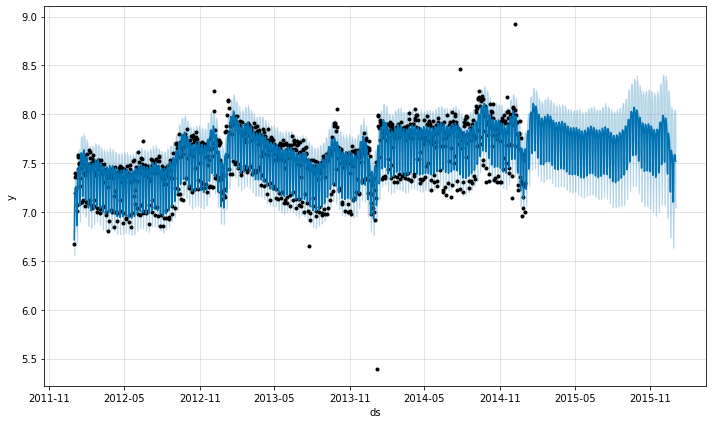

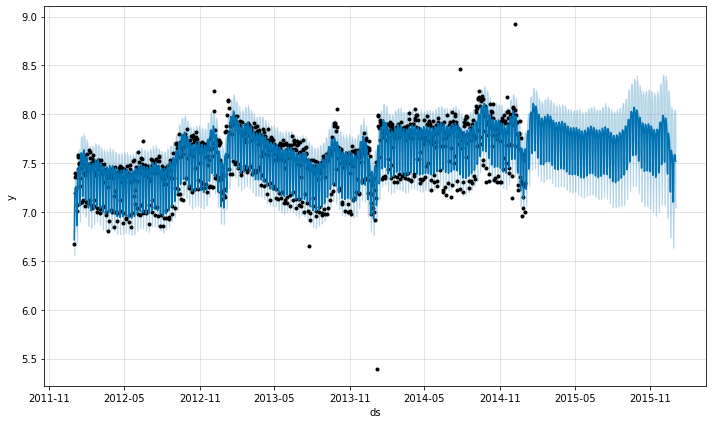

In [39]:
fmodel.plot(forecast)

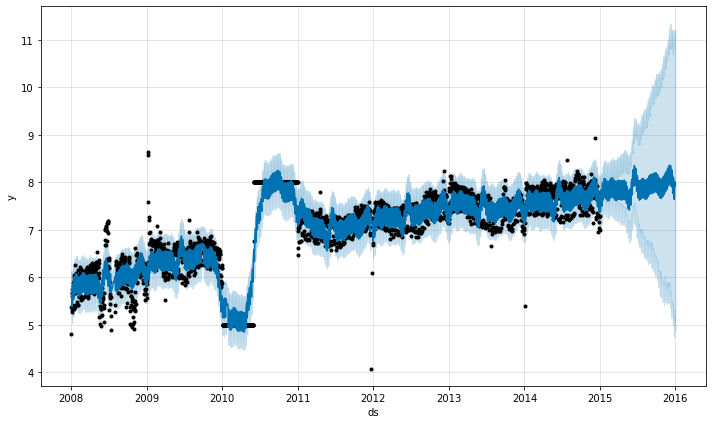

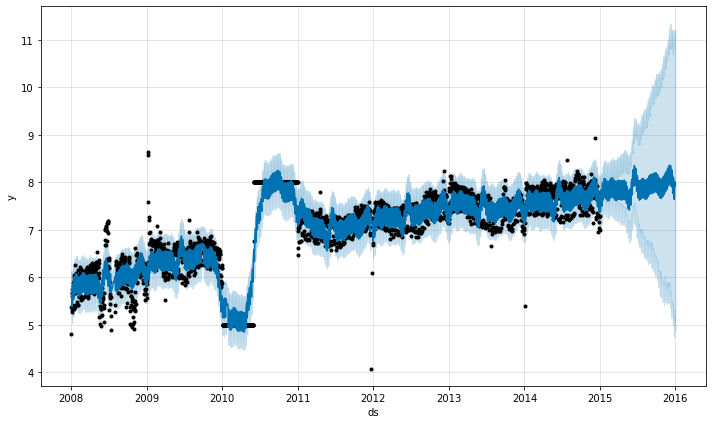

In [40]:
fmodel1.plot(forecast1)

# Автоматическая работа с пропущенными значениями (25%)

In [41]:
ts_copy = ts_full.copy()
ts_copy['y'][datetime(2010,1,1):datetime(2011,1,1)] = None
ts_copy[datetime(2010,1,1):datetime(2011,1,1)]

,ds,y
ds,,
2010-01-01,2010-01-01,NaN
2010-01-02,2010-01-02,NaN
2010-01-03,2010-01-03,NaN
2010-01-04,2010-01-04,NaN
2010-01-05,2010-01-05,NaN
2010-01-06,2010-01-06,NaN
2010-01-07,2010-01-07,NaN
2010-01-08,2010-01-08,NaN
2010-01-09,2010-01-09,NaN


In [42]:
fmodel2 = Prophet()

fmodel2.fit(ts_copy)
future2 = fmodel2.make_future_dataframe(periods=365)

forecast2 = fmodel2.predict(future2)

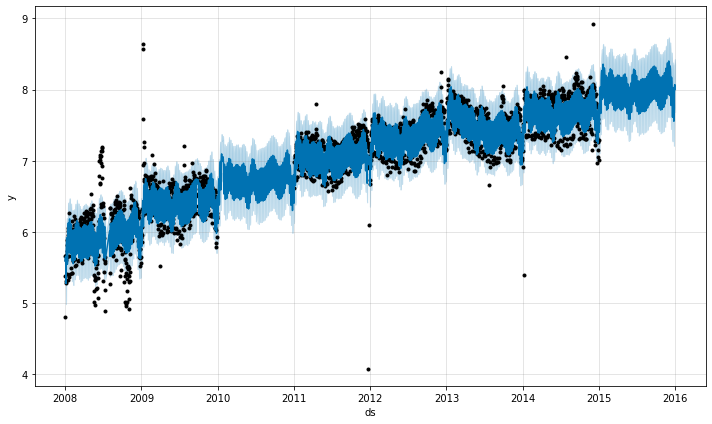

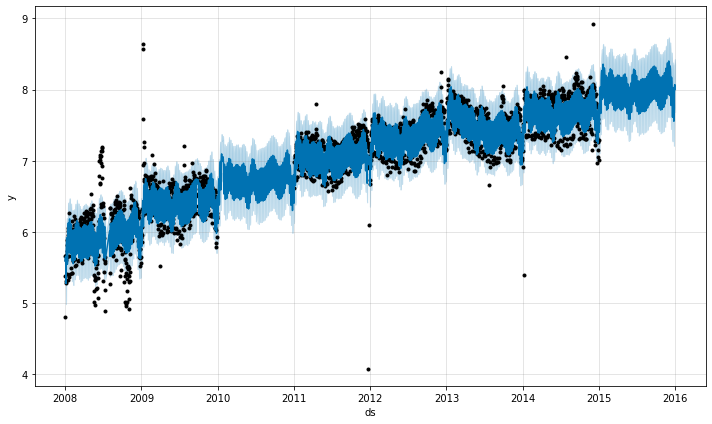

In [43]:
fmodel2.plot(forecast2)

In [44]:
cmp_df  = make_comparison_dataframe(ts_copy, forecast2)

In [45]:
import numpy as np
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100*cmp_df['e']/cmp_df['y']
print('MSE {}'.format(np.mean(abs(cmp_df[datetime(2015,1,1):]['p']))))
print('MAE {}'.format(np.mean(abs(cmp_df[datetime(2015,1,1):]['e']))))

MSE 11.157817127554539
MAE 0.7814906258367333


Добавление информации о выходных днях.

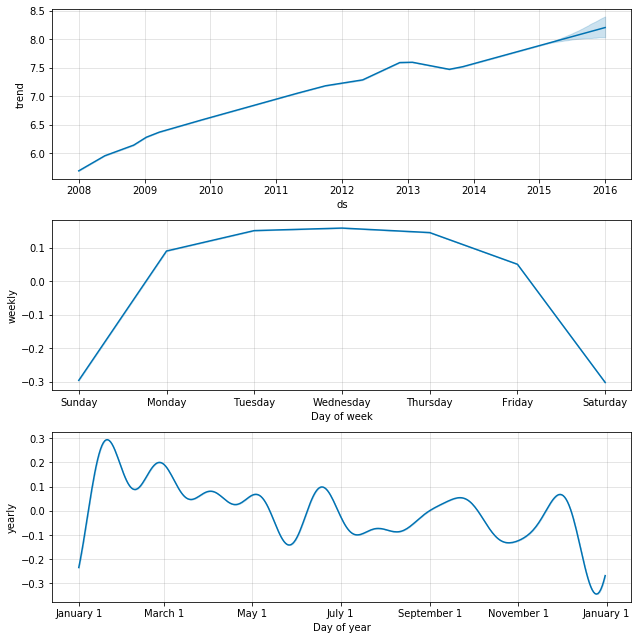

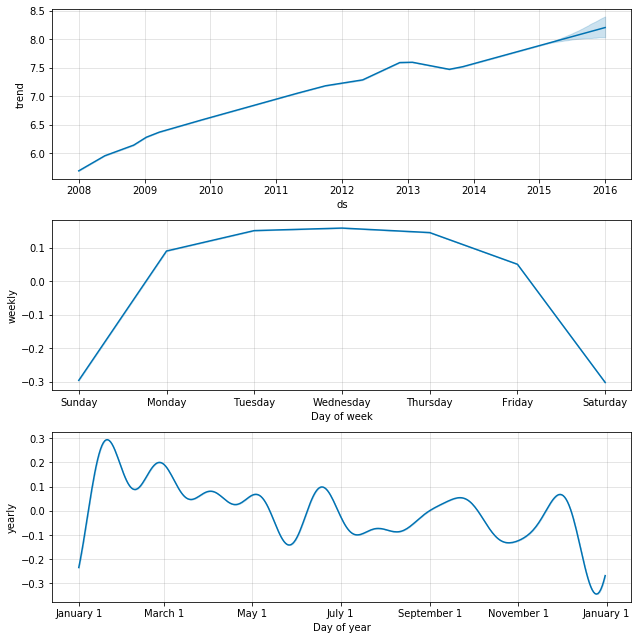

In [46]:
fmodel2.plot_components(forecast2)